In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

In [2]:
data_dir = "E:\\signal detection"
train_path = "E:\\signal detection\\Train"
test_path = "E:\\signal detection\\Test"
# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [3]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [4]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

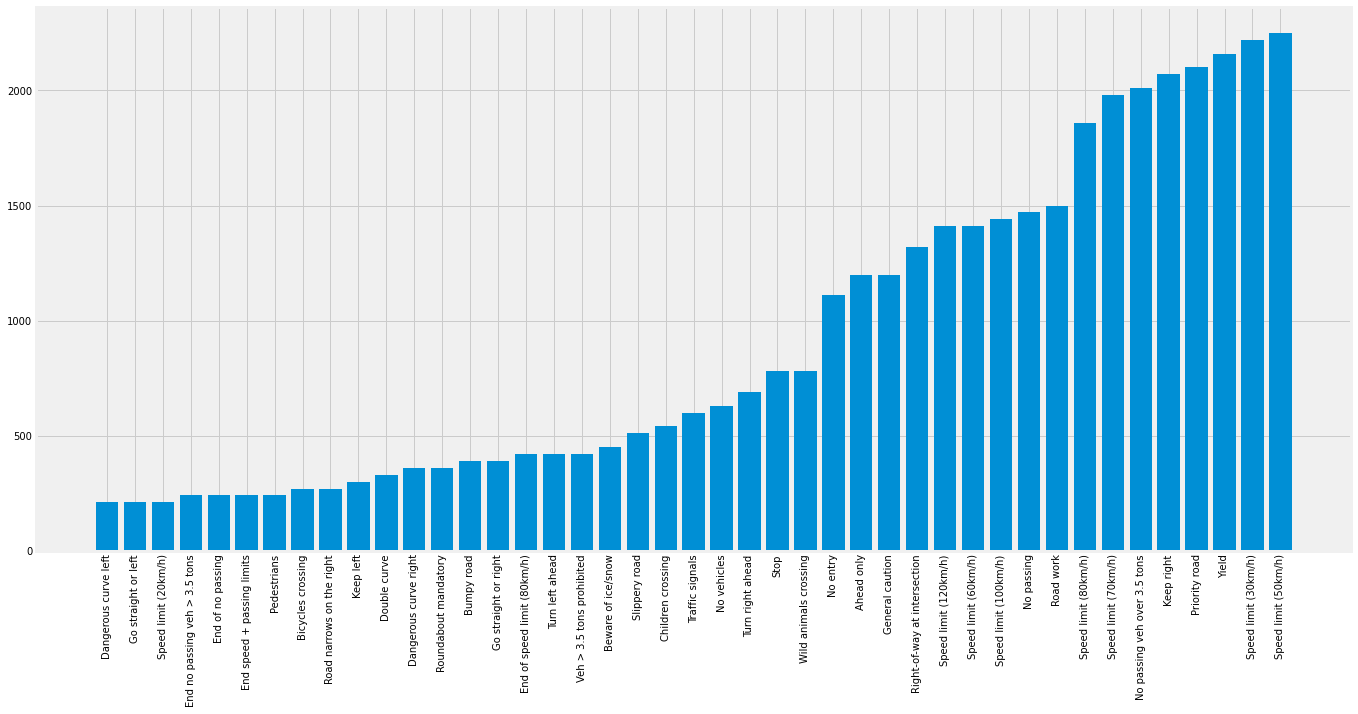

In [5]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_13580\1256017970.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


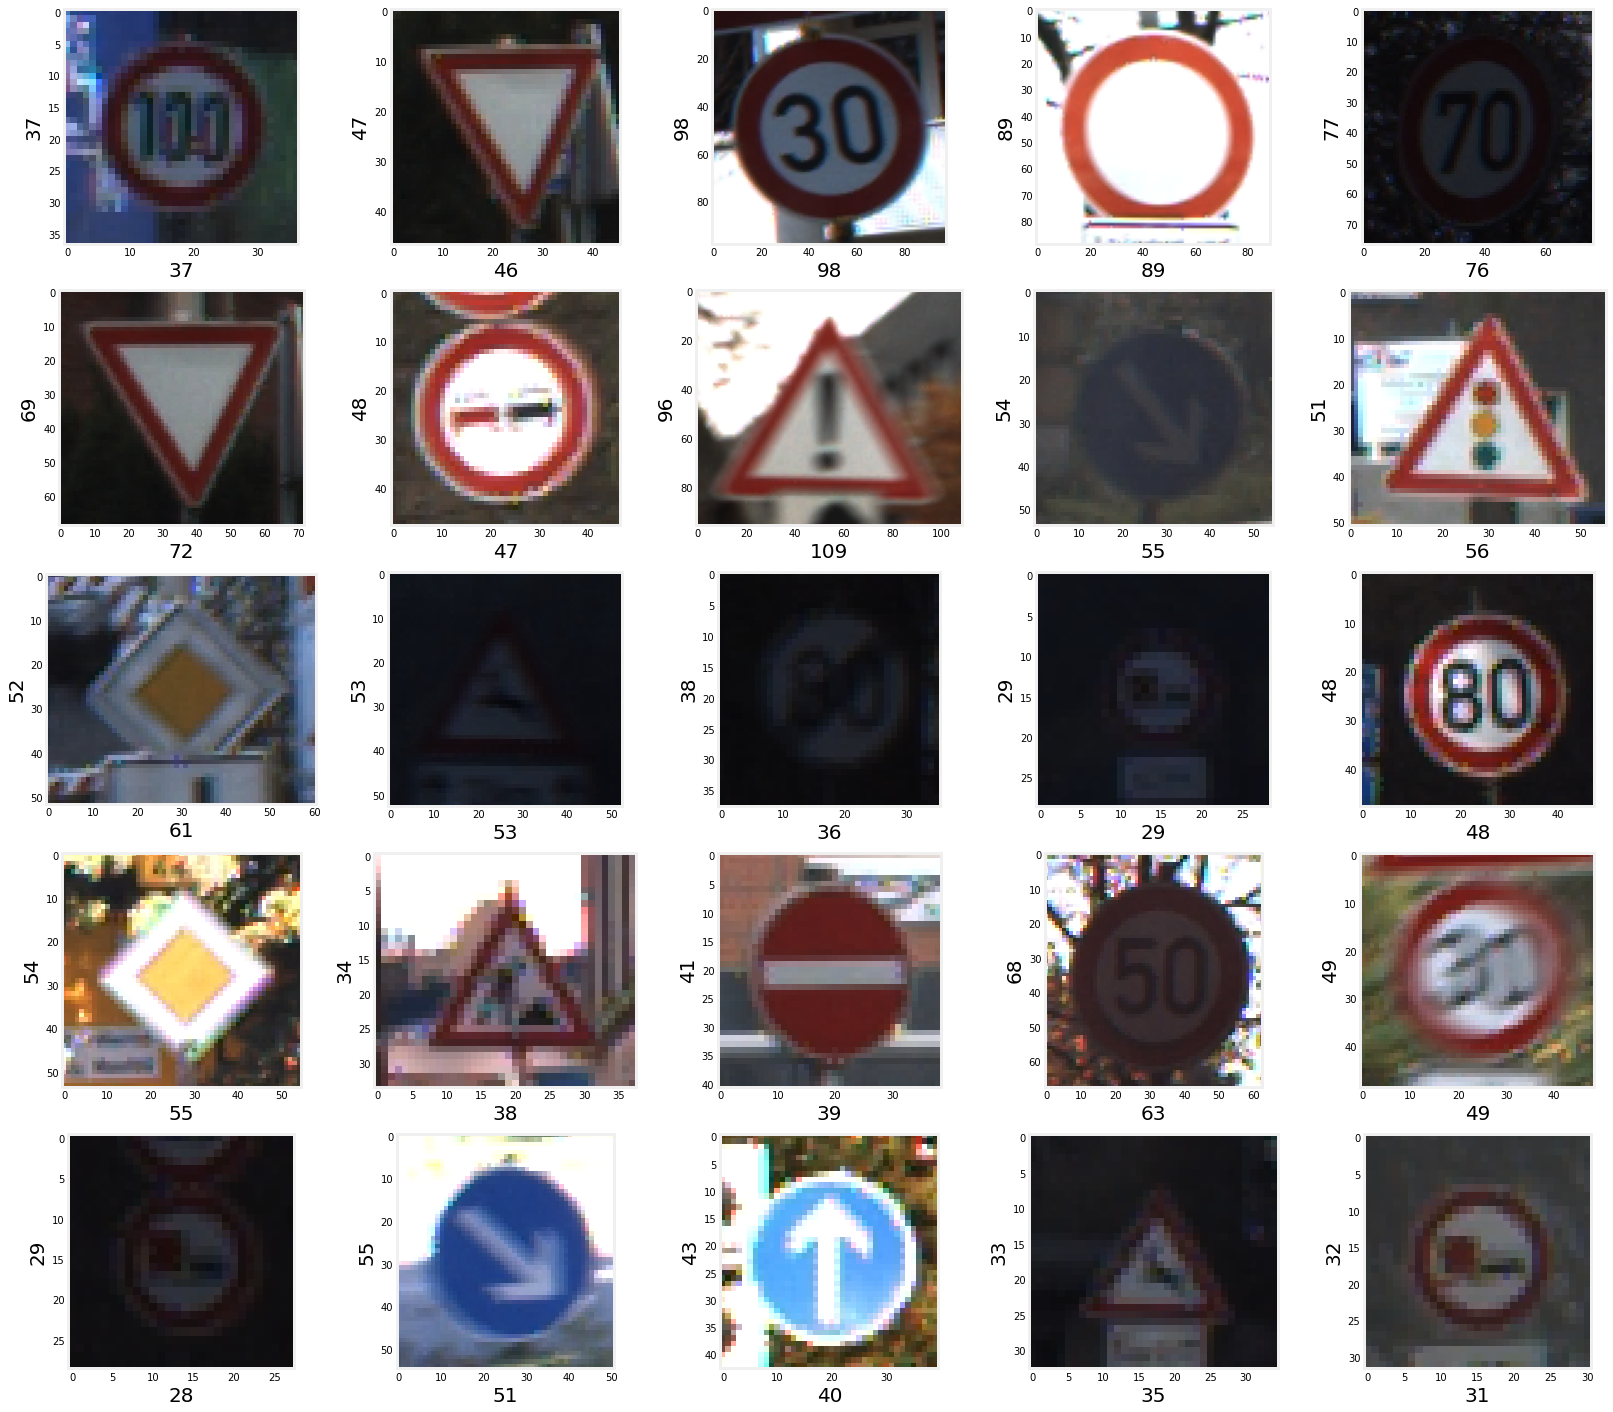

In [6]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

In [7]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


In [8]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [9]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [11]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


In [12]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

In [13]:
lr = 0.001
epochs = 30

opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - 41s 44ms/step - loss: 1.1341 - accuracy: 0.7006 - val_loss: 0.0733 - val_accuracy: 0.9760
Epoch 2/30
858/858 [==============================] - 39s 46ms/step - loss: 0.1924 - accuracy: 0.9403 - val_loss: 0.0417 - val_accuracy: 0.9873
Epoch 3/30
858/858 [==============================] - 41s 48ms/step - loss: 0.1075 - accuracy: 0.9683 - val_loss: 0.0288 - val_accuracy: 0.9908
Epoch 4/30
858/858 [==============================] - 39s 45ms/step - loss: 0.0870 - accuracy: 0.9739 - val_loss: 0.0147 - val_accuracy: 0.9955
Epoch 5/30
858/858 [==============================] - 40s 47ms/step - loss: 0.0692 - accuracy: 0.9791 - val_loss: 0.0150 - val_accuracy: 0.9947
Epoch 6/30
858/858 [==============================] - 41s 48ms/step - loss: 0.0630 - accuracy: 0.9806 - val_loss: 0.0196 - val_accuracy: 0.9941
Epoch 7/30
858/858 [==============================] - 45s 52ms/step - loss: 0.0487 - accuracy: 0.9856 - val_loss: 0.0103 - val_accuracy:

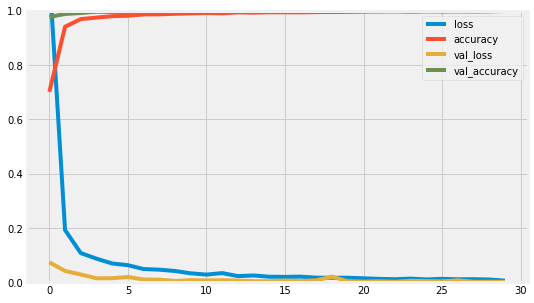

In [15]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [20]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

# pred = model.predict_classes(X_test)
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, classes_x)*100)

395/395 [==============================] - 4s 9ms/step
Test Data accuracy:  98.78859857482185


In [22]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, classes_x)

<AxesSubplot:>

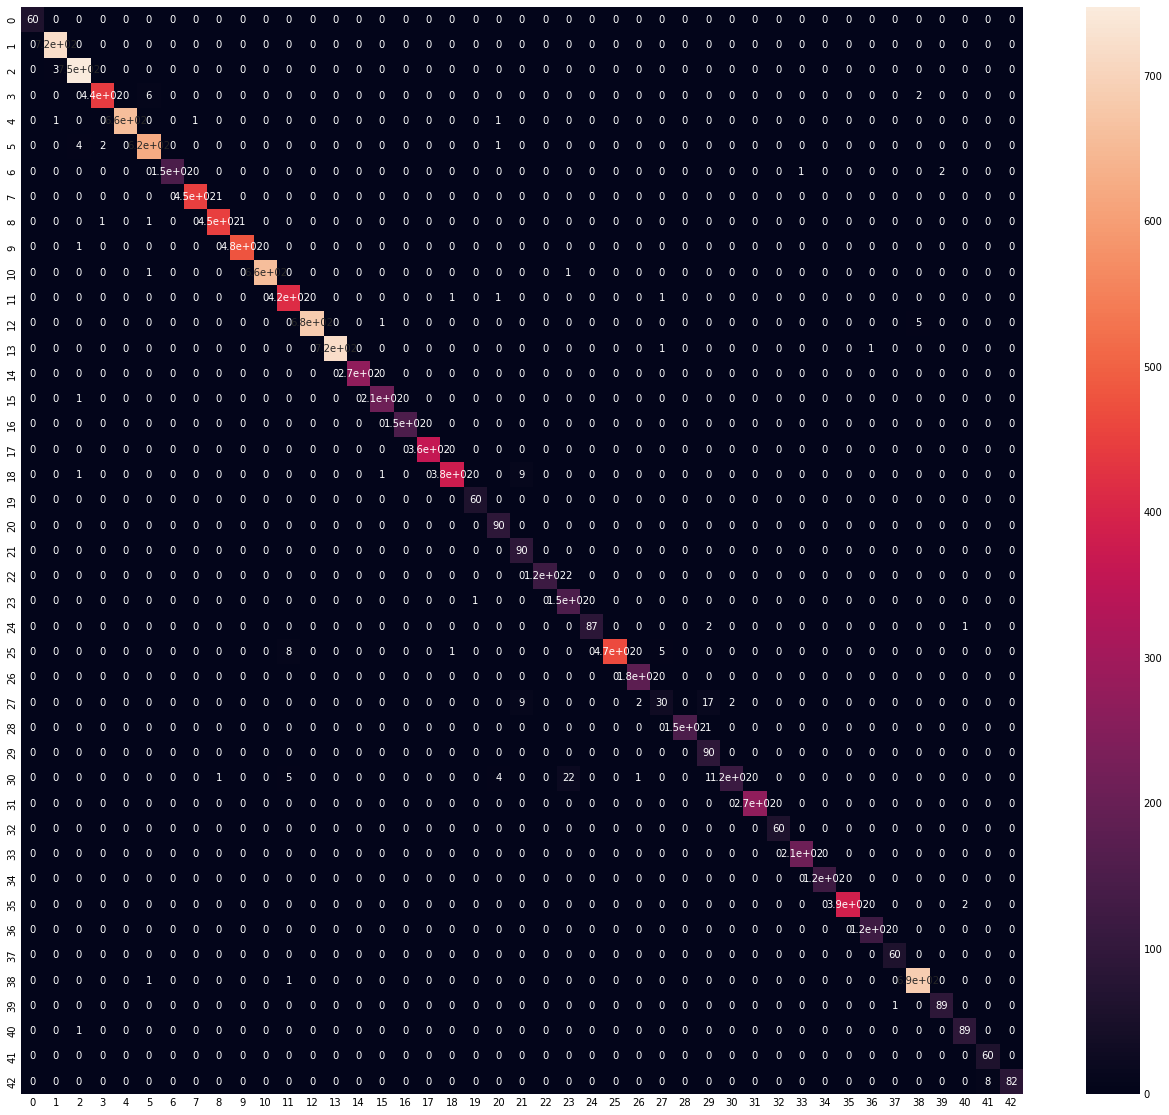

In [24]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [25]:
from sklearn.metrics import classification_report

print(classification_report(labels, classes_x))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      1.00       720
           2       0.99      1.00      0.99       750
           3       0.99      0.98      0.99       450
           4       1.00      1.00      1.00       660
           5       0.99      0.99      0.99       630
           6       1.00      0.98      0.99       150
           7       1.00      1.00      1.00       450
           8       1.00      0.99      0.99       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.97      0.99      0.98       420
          12       1.00      0.99      1.00       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.99      1.00      0.99       210
          16       1.00      1.00      1.00       150
          17       1.00    

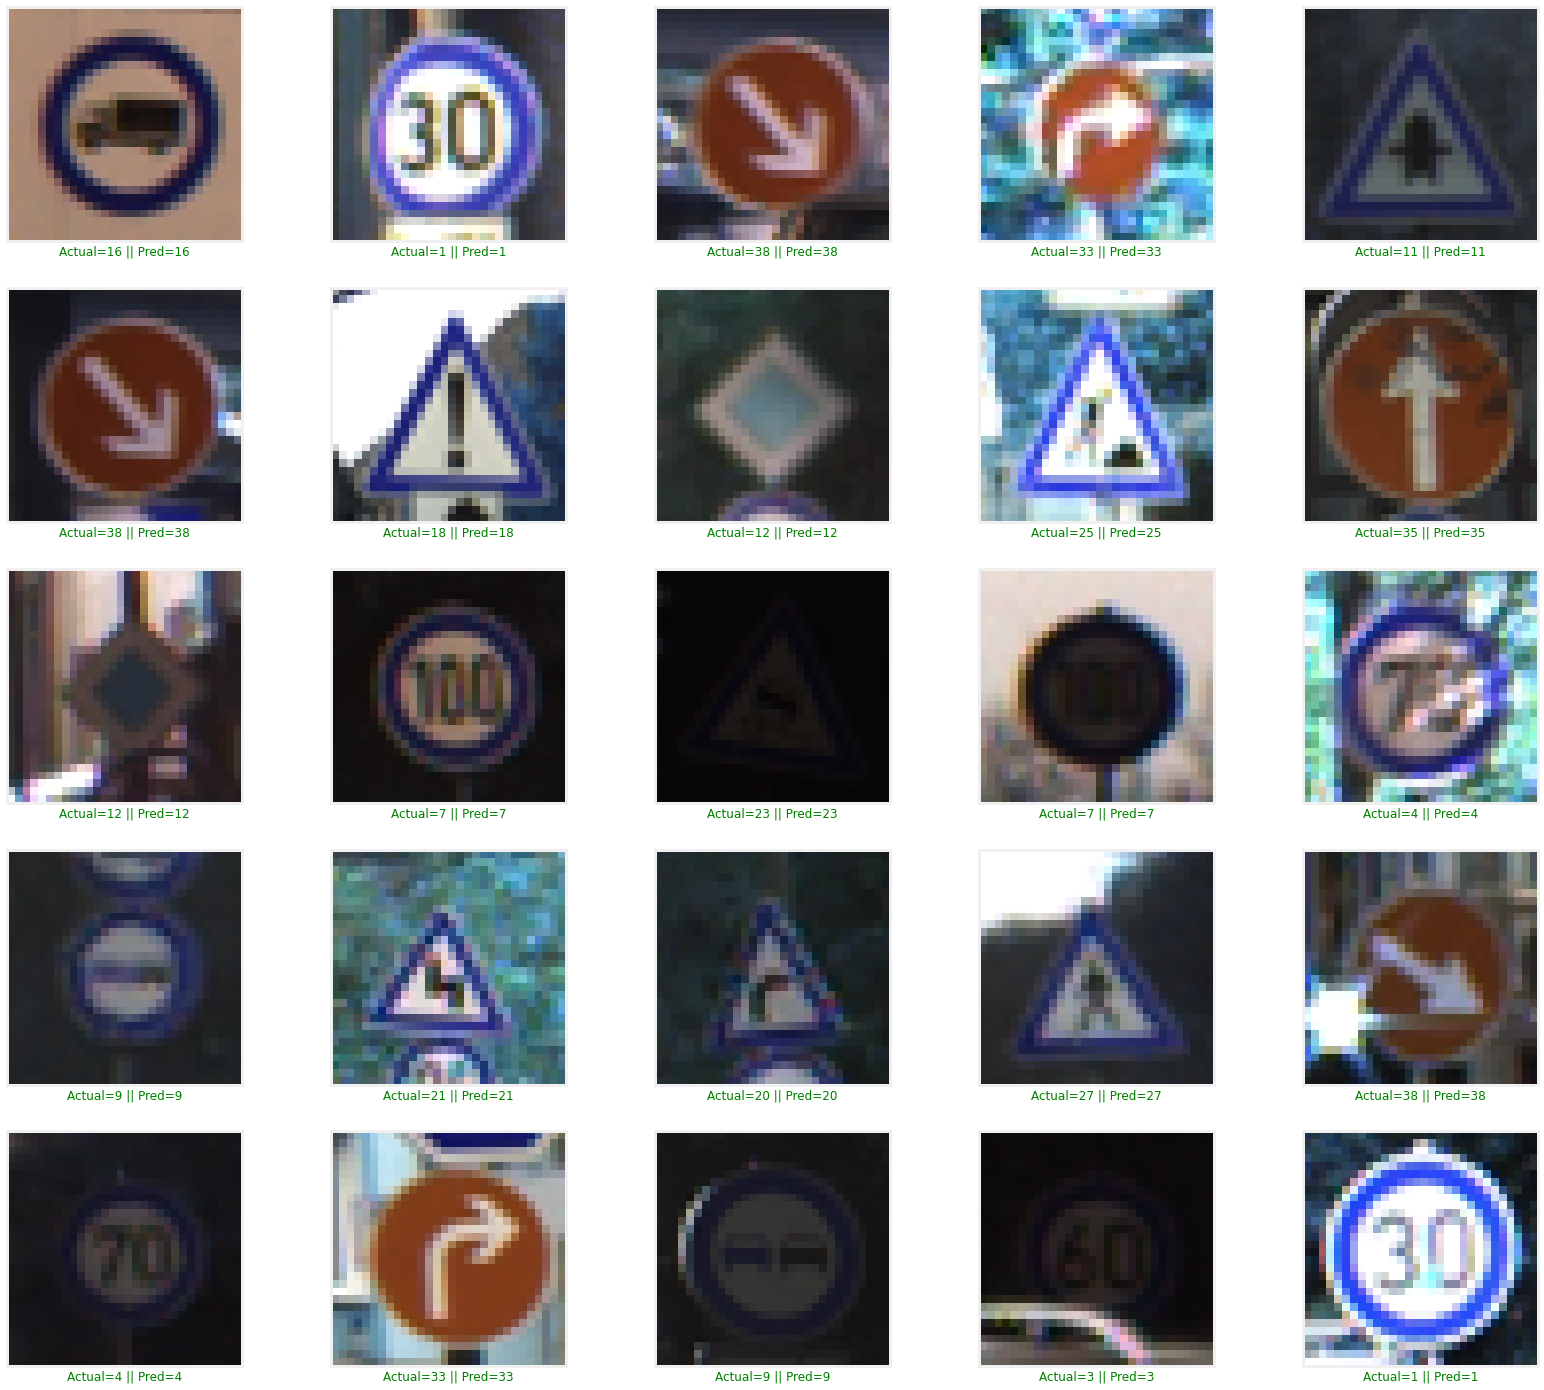

In [26]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = classes_x[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [44]:
image = cv2.imread("C:\\Users\\Dell\\Desktop\\STOP_sign.jpg")
image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
X_test = np.array(resize_image)
X_test = X_test/255
img = X_test.reshape(1, IMG_HEIGHT,IMG_WIDTH , channels)
predict_x=model.predict(img) 
classes_x=np.argmax(predict_x,axis=1)

1/1 [==============================] - 0s 22ms/step


In [45]:
classes_x

array([14], dtype=int64)